## Procesamiento de Lenguaje Natural

*Proyecto Final: **Modelado de Tópicos*** 

# ***Análisis exploratorio de datos***

### **Equipo:**

- Giottonini Herrera Enrique Alejandro
- Burruel Durán Luis Andrés
- Villalba Miranda Jesús Abraham
- Oscar Eduardo Galaviz Cuen

**Fuentes**
* Los datos fueron obtenidos de [@nostradata ](https://www.nostrodata.com) en [`GitHub`](https://github.com/NOSTRODATA/conferencias_matutinas_amlo)
---

In [35]:
# Importamos las librerias que utilizaremos
import os
import re
import spacy
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

## **Objetivo**

El propósito es realizar un análisis exploratorio sobre los datos crudos para tener una base en la toma de desiciones con respecto al pre-procesamiento de datos (limpieza, normalización, etc.) para nuestra tarea final, el `modelado de topicos`.

Es importante señalar la estructura de los documentos o datos crudos que estaremos analizando y que formato deseamos como resultado del preprocesamiento para el entrenamiento del modelo que utilizaremos para el modelado de topicos. Los documentos vienen separados en archivos diferentes, en el que cada archivo contiene las mañaneras ocurridas en la semana correspondiente.

Lo que esperamos producir como salida es un archivo `csv` que contenga los **tokens** identificados de la semana despues del preprocesamiento del texto.

### Extracción de información de los archivos

In [36]:
def getData(filename: str) -> str:
    """ Lee y almacena en un string todos los carácteres leídos en un archivo .txt """
    rawData = ""
    with open(filename, encoding="utf-8") as f:
        for line in f:
            rawData += line
    return rawData

In [37]:
available_data_paths = os.listdir(path='../data/')

Para la tarea que estamos resolviendo consideramos pertinente analizar nuestro corpus realizando un preprocesamiento sencillo de convertir todos nuestros caracteres alfanumericos a minusculas.

In [38]:
df = pd.DataFrame(columns=['text', 'week'])
for file_name in available_data_paths:
    date = datetime.datetime.strptime(file_name.split('.')[0], '%d-%m-%Y')
    df.loc[len(df)] = [getData(f'../data/{file_name}').lower(), date]

print(f"Se encontraron {len(df)} documentos en el corpus")

Se encontraron 219 documentos en el corpus


Ordenamos el dataset por fecha

In [39]:
eda_df = df.sort_values(by='week')

## Estadisticas simples

En esta sección analizaremos información basica de nuestros documentos, como la cantidad de palabras por documento, cantidad de sentencias por documento, etc. 

In [40]:
eda_df['words'] = df['text'].apply(lambda x: word_tokenize(x, 'spanish'))
eda_df['sentences'] = df['text'].apply(lambda x: sent_tokenize(x, 'spanish'))
eda_df['num_ch'] = df['text'].apply(lambda x: len(x))

In [41]:
eda_df.head()

,text,week,words,sentences,num_ch
19,muy buenos días. estamos terminando la reunió...,2018-12-03,"[muy, buenos, días, ., estamos, terminando, la...","[ muy buenos días., estamos terminando la reun...",86844
69,"buenas tardes. sí. es que son buenos días, pe...",2018-12-10,"[buenas, tardes, ., sí, ., es, que, son, bueno...","[ buenas tardes., sí., es que son buenos días,...",33001
171,": muy buenos días. el día de hoy, antes que ni...",2018-12-24,"[:, muy, buenos, días, ., el, día, de, hoy, ,,...","[: muy buenos días., el día de hoy, antes que ...",102296
218,": buenos días. primero, reiterar nuestra manif...",2018-12-31,"[:, buenos, días, ., primero, ,, reiterar, nue...","[: buenos días., primero, reiterar nuestra man...",109652
41,: buenos días. ánimo. hoy vamos a tratar dos t...,2019-01-07,"[:, buenos, días, ., ánimo, ., hoy, vamos, a, ...","[: buenos días., ánimo., hoy vamos a tratar do...",190191


#### Número de caracteres por documento (semana)

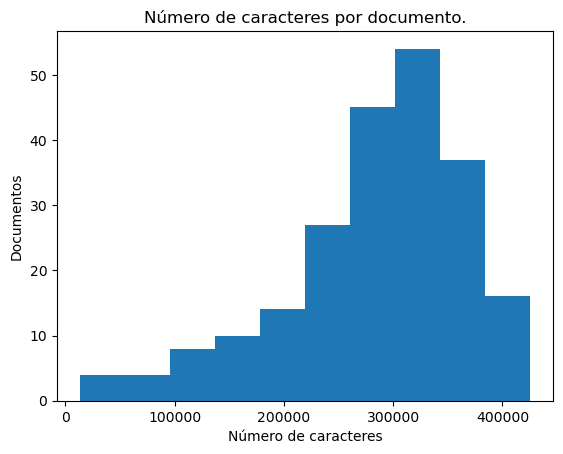

In [42]:
plt.hist(eda_df['num_ch'])
plt.title('Número de caracteres por documento.')
plt.xlabel('Número de caracteres')
plt.ylabel('Documentos')
plt.show()

#### Número de palabras por semana.

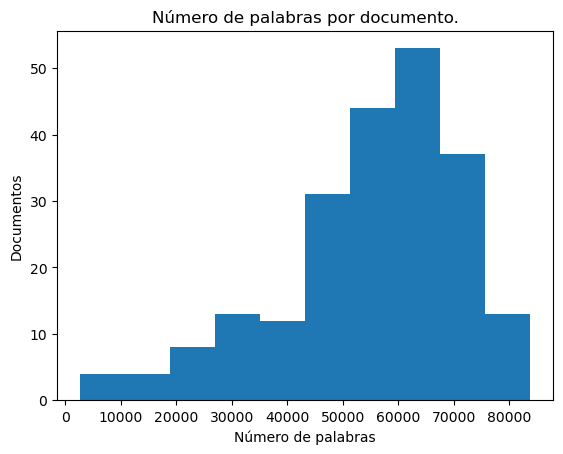

In [43]:
plt.hist(eda_df['words'].apply(lambda x: len(x)))
plt.title('Número de palabras por documento.')
plt.xlabel('Número de palabras')
plt.ylabel('Documentos')
plt.show()

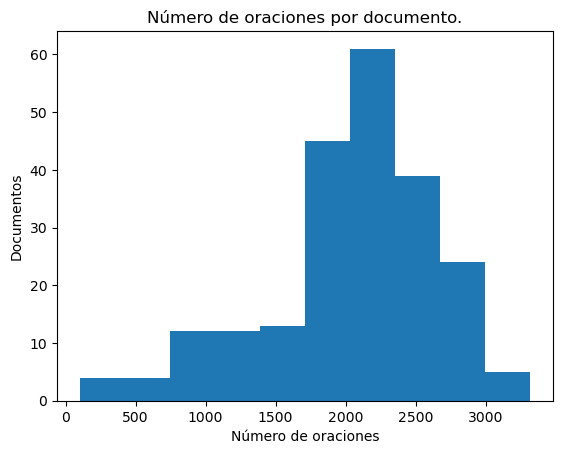

In [44]:
plt.hist(eda_df['sentences'].apply(lambda x: len(x)))
plt.title('Número de oraciones por documento.')
plt.xlabel('Número de oraciones')
plt.ylabel('Documentos')
plt.show()

#### Longitud promedio de palabras por documento.

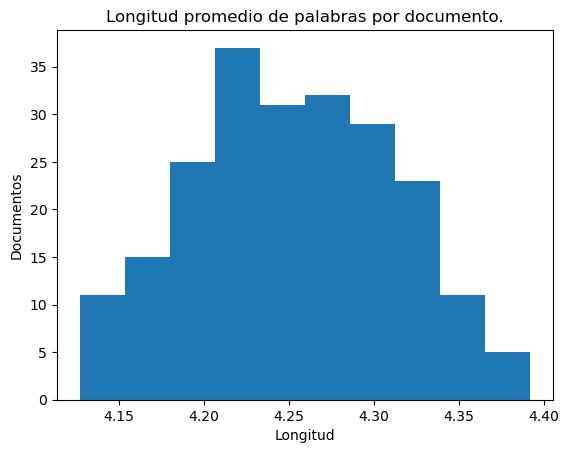

In [45]:
plt.hist(eda_df['words'].apply(lambda x: np.mean([len(i) for i in x])))
plt.title('Longitud promedio de palabras por documento.')
plt.xlabel('Longitud')
plt.ylabel('Documentos')
plt.show()

## Palabras más repetidas.

Para realizar este analisis y considerando la tarea que queremos realizar, consideramos pertinente realizar un preprocesamiento basico de nuestro corpus antes de obtener las palabras más repetidas de nuestro corpus. 

El preprocesamiento que consideramos pertinente es:
 * Quedarnos solamente con caracteres alfanumericos.
 * Remover `stopwords`.

In [46]:
stop_words = stopwords.words('spanish')

In [47]:
clean_word = lambda word: re.sub(r'[^a-záíóúéñ]',"",word)

def basic_preprocessing(text: str) -> str:
    text = text.strip()
    tokens = word_tokenize(text)
    tokens = [clean_word(word) for word in tokens if clean_word(word)] 
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [48]:
eda_df['clean'] =  eda_df['text'].apply(basic_preprocessing)
print(eda_df[['clean']].head())

                                                 clean
19   buenos días terminando reunión seguridad infor...
69   buenas tardes buenos días llegué tarde tratand...
171  buenos días día hoy ningún asunto vamos inform...
218  buenos días primero reiterar manifestación des...
41   buenos días ánimo hoy vamos tratar dos temas c...


#### Funciones auxiliares

In [49]:
def get_vocab(corpus) -> defaultdict:
    """Gets the vocabulary of a corpus."""
    vocab = defaultdict(int)
    for doc in corpus:
        for word in word_tokenize(doc):
            vocab[word] += 1
    return vocab

""" Función para ordenar el vocabulario de mayor a menor frecuencia"""
sort_vocab = lambda vocab: sorted(vocab.items(), key=lambda x: x[1], reverse=True)

In [50]:
def get_most_n_frequent_tokens(vocab, n=10):
    """Gets the n most frequent tokens in a corpus."""
    return sort_vocab(vocab)[:n]

In [51]:
def plot_n_most_frequent_tokens(vocab, n=10, title='') -> None:
    """Plots the n most frequent tokens in a corpus."""
    tipos = get_most_n_frequent_tokens(vocab, n)
    token, freq = zip(*tipos)
    sns.barplot(x=list(freq), y=list(token)).set(title=title)

In [52]:
vocab = get_vocab(eda_df['clean'])

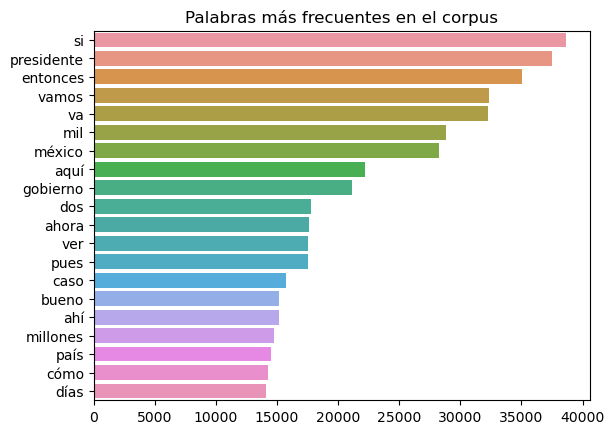

In [53]:
plot_n_most_frequent_tokens(vocab, 20, 'Palabras más frecuentes en el corpus')

### TOP-10 N-GRAMAS

## Bigramas más frecuentes

In [54]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<Axes: >

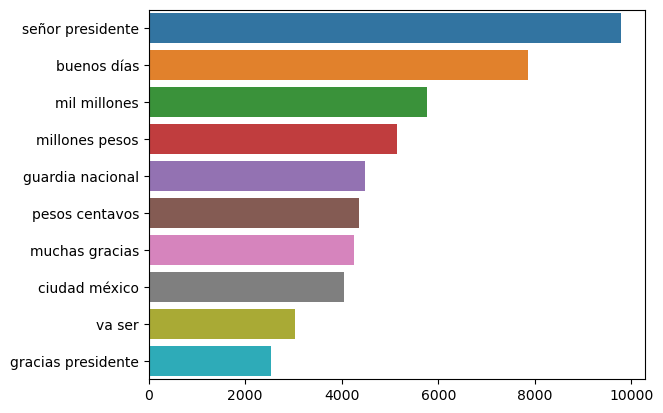

In [55]:
top_bigrams=get_top_ngram(eda_df['clean'],n=2)
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

<Axes: >

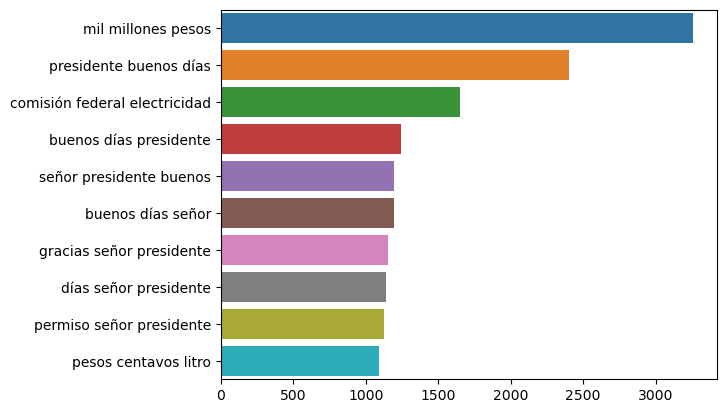

In [56]:
top_trigrams=get_top_ngram(eda_df['clean'],n=3)
x,y=map(list,zip(*top_trigrams))
sns.barplot(x=y,y=x)

## POS Tagging y lematización.

In [7]:
!python -m spacy download es_core_news_sm

     --------------------------------------- 12.9/12.9 MB 16.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')



[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
nlp = spacy.load('es_core_news_sm')

In [58]:
def lematizar(text : str) -> str:
    """Lemmatize a text."""
    doc = nlp(text, disable=['parser', 'ner', 'tagger', 'textcat'])
    return ' '.join([token.lemma_ for token in doc])

In [59]:
def get_tags(text : str) -> list:
    """Get the tags of a text."""
    doc = nlp(text, disable=['parser', 'ner', 'textcat', 'lemmatizer'])
    return ' '.join([token.tag_ for token in doc])

In [60]:
eda_df['lemmatized'] = eda_df['clean'].apply(lematizar)
eda_df['tags'] = eda_df['lemmatized'].apply(get_tags)

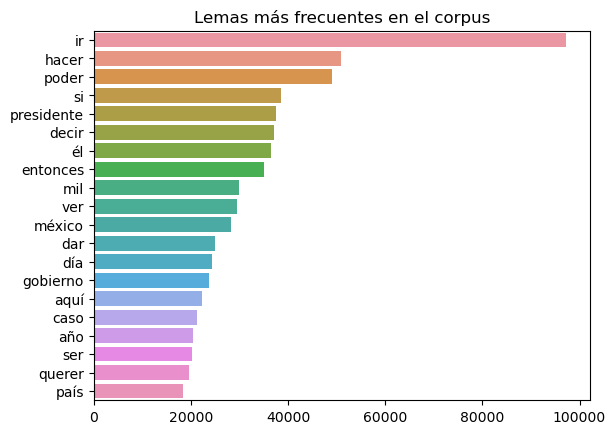

In [61]:
lemmas_v = get_vocab(eda_df['lemmatized'])
plot_n_most_frequent_tokens(lemmas_v, 20, 'Lemas más frecuentes en el corpus')

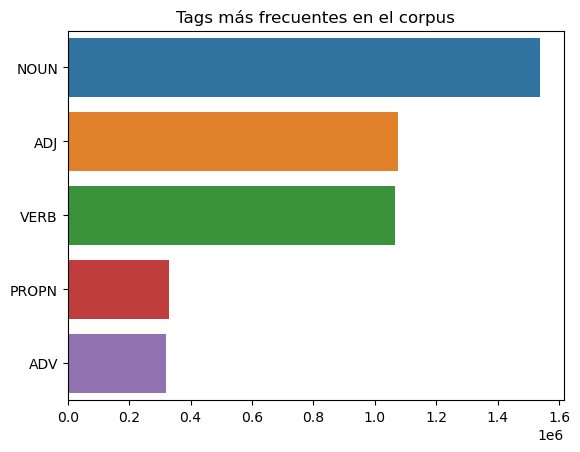

In [62]:
tags_v = get_vocab(eda_df['tags'])
plot_n_most_frequent_tokens(tags_v, 5, 'Tags más frecuentes en el corpus')

### Limpiando nuestros datos

Considerando nuestra tarea y considerando los datos con los que contamos, decidimos que el preprocesamiento que aplicaremos a nuestros datos consistirá de los siguientes pasos:
 1. Convertir nuestras corpus a minuscula.
 2. Conservar solamente las palabras.
 3. Eliminar stopwords
 4. Lematizar
 5. Conservar tokens con tags `NOUN`, `ADJ`, `VERB` y `ADV`.
 6. Conservar tokens relvantes, es decir, si un token se repite mucho en todos los documentos, este no proporcionara información util.

Hasta ahora ya contamos con los primeros 4 pasos.

In [63]:
def remove_tags(text: str, allowed_tags : list = ["NOUN", "ADJ", "VERB", "ADV"]) -> str:
    """Remove tags that are not in 'allowed_tags' from a text."""
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.pos_ in allowed_tags]
    return ' '.join(tokens)

eda_df['clean_lemmatized'] = eda_df['lemmatized'].apply(remove_tags)

In [64]:
clean_corpus = eda_df[['week']].copy()
clean_corpus['text'] = eda_df['clean_lemmatized'].copy()

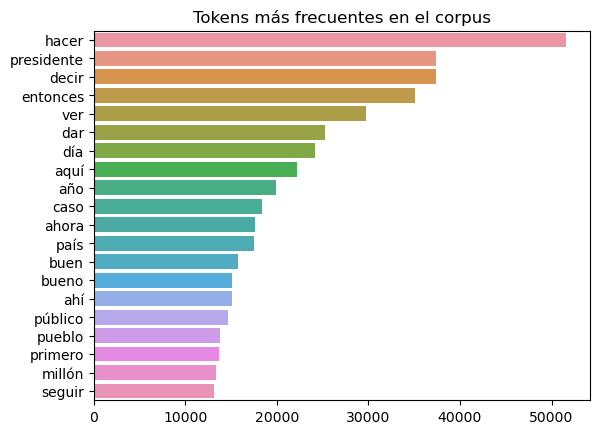

In [65]:
vocab = get_vocab(clean_corpus['text'])
plot_n_most_frequent_tokens(vocab, 20, 'Tokens más frecuentes en el corpus')

In [66]:
clean_corpus.head()

,week,text
19,2018-12-03,buen día terminar reunión seguridad obtener in...
69,2018-12-10,buen tarde buen día llegar tarde tratar tema i...
171,2018-12-24,buen día día hoy asunto informar lamentable ca...
218,2018-12-31,buen día primero reiterar manifestación desear...
41,2019-01-07,buen día ánimo hoy tratar tema contestar siemp...


In [67]:
clean_corpus.to_csv('../clean_corpus.csv', index=False)